In [162]:
	
from statsbombpy import sb
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter

In [163]:
events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2023/2024",
    gender="male"
)

/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarni

In [ ]:
#make a list to hold a df of the events of a match
df_lst = []

for id in events.match_id.unique():
    #find one match for one team
    match_subset = events.loc[events['match_id'] == id]

    #we identify the starting 11
    starting_11 = match_subset.loc[match_subset['type'] == 'Starting XI'].loc[match_subset['team'] == 'Bayer Leverkusen', 'tactics'].to_list()[0]
    position_dict = {}
    
    #we make a dictionary for positions of players
    for member in starting_11['lineup']:
        player_id = int(member['player']['id'])
        position_name = member['position']['name']
        position_dict[player_id] = position_name


    match_subset = match_subset.loc[match_subset['possession_team'] == 'Bayer Leverkusen']

    #include only passes and shots
    match_subset = match_subset.loc[(match_subset['type'] == 'Shot') | (match_subset['type'] =='Pass')| (match_subset['type'] =='Substitution')]

    #sort the values like when we did the passing sequences
    match_subset = match_subset.sort_values(['period','timestamp'], ascending=[True, True])

    match_subset['pass_recipient_position'] = np.nan

    for index, row in match_subset.iterrows():
        #If substitution, we update the dictionary to include player
        if row['type'] == 'Substitution':
            position_dict[row['substitution_replacement_id']] = row['position']
    
        elif row['pass_recipient_id'] in list(position_dict.keys()):
            #if the player is in our dictionary, we assign his position - else he may be a player of the opponent, and we ignore him
            match_subset.at[index, 'pass_recipient_position'] = position_dict[int(row['pass_recipient_id'])]
    
            if row['player_id'] in list(position_dict.keys()) and row['position'] != position_dict[row['player_id']]:
                #if a player is listed with a position different to what we have for him, we overwrite our current position
                position_dict[row['player_id']] = row['position']
            
    #den næste linje kan eventuelt kommenteres ud, og så kan vi bare fjerne na i stedet, hvis vi ikke vil have de ekstra nodes, jeg foreslår :D

    #add shot as a pass recipient as well
    match_subset.loc[match_subset['type'] =='Shot', 'pass_recipient_position'] = match_subset.apply(lambda x: np.where(pd.isna(x['pass_recipient_position']), x['shot_outcome'], x['pass_recipient_position']), axis=1)

    #if a does not have a pass_recipient_position yet, we drop it
    match_subset.dropna(subset=['pass_recipient_position'], inplace = True)

    df_lst.append(match_subset)   

/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_15213/3776169055.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_subset['pass_recipient_position'] = np.nan
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_15213/3776169055.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Goalkeeper' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  match_subset.at[index, 'pass_recipient_position'] = position_dict[int(row['pass_recipient_id'])]
/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_15213/3776169055.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

In [165]:
#dictionary for the graphs
match_graph_dict = {}

#iterate through the dfs
for match in df_lst:
    match_id = match['match_id'].iloc[0]
    graph = nx.DiGraph()
    edges = []

    #iterate through the passings of the match
    for node in pd.concat([match['position'], match['pass_recipient_position']], axis=0):
        if str(node) not in list(graph.nodes):
            #add the node to the graph
            graph.add_node(str(node))

    for passing in match[['position', 'pass_recipient_position']].itertuples():
        edge = (str(passing.position), str(passing.pass_recipient_position))
        edges.append(edge)

    #count the frequencies
    edges_counter = Counter(edges)

    edge_and_count = [(edge[0], edge[1], edges_counter[edge]) for edge in edges]

    #add weighted edges to graph
    graph.add_weighted_edges_from(edge_and_count)

    #add finished graph to dictionary
    match_graph_dict[match_id] = graph

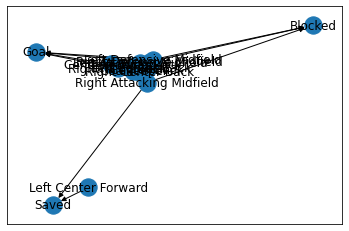

In [166]:
nx.draw_networkx(match_graph_dict[3895333])